# Введение в PCA, ICA и кластеризацию для биологов

В этой тетрадке мы рассмотрим три важных метода анализа данных, широко применяемых в биоинформатике:
- **PCA (Principal Component Analysis)** — метод главных компонент
- **ICA (Independent Component Analysis)** — анализ независимых компонент
- **Кластеризация** — методы группировки объектов

In [1]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from scipy.cluster.hierarchy import dendrogram, linkage

# Настройка визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. PCA (Метод главных компонент)

### Что это такое?
PCA — это метод снижения размерности, который находит новые оси (главные компоненты) в данных так, чтобы максимизировать дисперсию вдоль этих осей.

### Зачем биологу?
- Визуализация многомерных данных (например, экспрессия генов)
- Удаление шума из данных
- Поиск скрытых паттернов в данных
- Ускорение вычислений за счет уменьшения числа признаков

### Биологический пример
Представьте, что вы измерили экспрессию 20,000 генов в разных образцах. PCA поможет найти главные "направления" изменчивости и визуализировать образцы в 2D.

In [2]:
# Загрузим классический датасет Iris (параметры цветков ириса)
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Создадим DataFrame для удобства
df = pd.DataFrame(X, columns=feature_names)
df['species'] = [target_names[i] for i in y]

print("Размерность данных:", X.shape)
print("\nПервые строки:")
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
# Стандартизация данных (важно для PCA!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Применяем PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Создаем DataFrame с результатами
df_pca = pd.DataFrame(
    X_pca,
    columns=['PC1', 'PC2']
)
df_pca['species'] = df['species']

print(f"Объясненная дисперсия каждой компоненты: {pca.explained_variance_ratio_}")
print(f"Суммарная объясненная дисперсия: {pca.explained_variance_ratio_.sum():.2%}")

Объясненная дисперсия каждой компоненты: [0.72962445 0.22850762]
Суммарная объясненная дисперсия: 95.81%


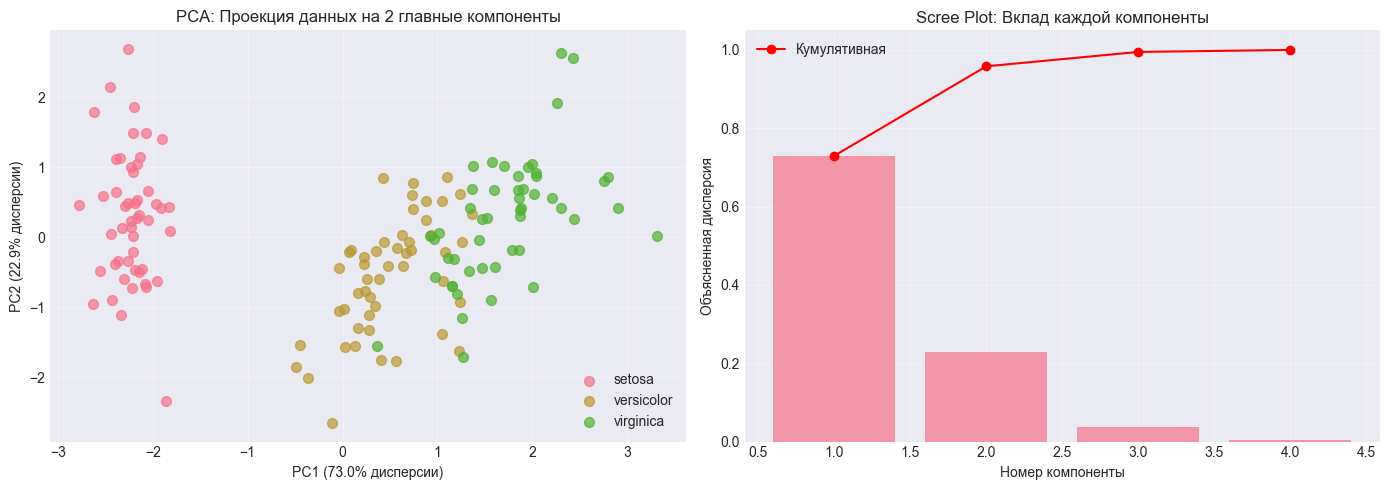

In [4]:
# Визуализация результатов PCA
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: PCA проекция
for species in target_names:
    mask = df_pca['species'] == species
    axes[0].scatter(
        df_pca[mask]['PC1'],
        df_pca[mask]['PC2'],
        label=species,
        s=50,
        alpha=0.7
    )

axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} дисперсии)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} дисперсии)')
axes[0].set_title('PCA: Проекция данных на 2 главные компоненты')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График 2: Scree plot (объясненная дисперсия)
pca_full = PCA()
pca_full.fit(X_scaled)
axes[1].bar(
    range(1, len(pca_full.explained_variance_ratio_) + 1),
    pca_full.explained_variance_ratio_,
    alpha=0.7
)
axes[1].plot(
    range(1, len(pca_full.explained_variance_ratio_) + 1),
    np.cumsum(pca_full.explained_variance_ratio_),
    'ro-',
    label='Кумулятивная'
)
axes[1].set_xlabel('Номер компоненты')
axes[1].set_ylabel('Объясненная дисперсия')
axes[1].set_title('Scree Plot: Вклад каждой компоненты')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

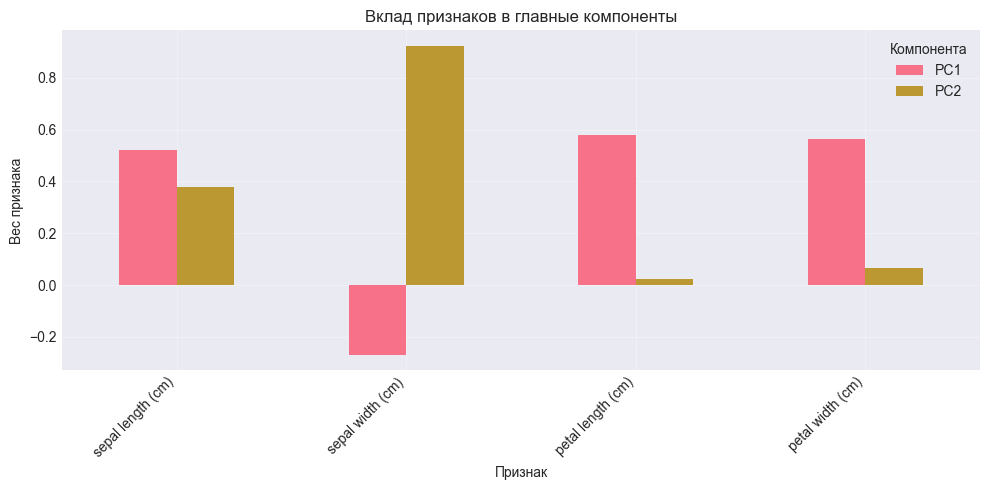

In [5]:
# Интерпретация главных компонент
components_df = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_names
)

print("Вклад каждого признака в главные компоненты:")
print(components_df)

# Визуализация вкладов
components_df.plot(kind='bar', figsize=(10, 5))
plt.title('Вклад признаков в главные компоненты')
plt.ylabel('Вес признака')
plt.xlabel('Признак')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Компонента')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. ICA (Анализ независимых компонент)

### Что это такое?
ICA — это метод, который разделяет многомерный сигнал на независимые компоненты. В отличие от PCA, ICA ищет статистически независимые источники.

### Зачем биологу?
- Разделение смешанных сигналов (например, ЭЭГ, fMRI)
- Анализ экспрессии генов: разделение сигналов от разных биологических процессов
- Удаление артефактов из данных

### Биологический пример
В данных экспрессии генов могут смешиваться сигналы от разных клеточных процессов. ICA помогает "распутать" эти сигналы.

In [6]:
# Применяем ICA
ica = FastICA(n_components=2, random_state=42)
X_ica = ica.fit_transform(X_scaled)

# Создаем DataFrame с результатами
df_ica = pd.DataFrame(
    X_ica,
    columns=['IC1', 'IC2']
)
df_ica['species'] = df['species']

In [7]:
# Сравнение PCA и ICA
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PCA
for species in target_names:
    mask = df_pca['species'] == species
    axes[0].scatter(
        df_pca[mask]['PC1'],
        df_pca[mask]['PC2'],
        label=species,
        s=50,
        alpha=0.7
    )

axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('PCA: Главные компоненты')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ICA
for species in target_names:
    mask = df_ica['species'] == species
    axes[1].scatter(
        df_ica[mask]['IC1'],
        df_ica[mask]['IC2'],
        label=species,
        s=50,
        alpha=0.7
    )

axes[1].set_xlabel('IC1')
axes[1].set_ylabel('IC2')
axes[1].set_title('ICA: Независимые компоненты')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nРазница между PCA и ICA:")
print("- PCA ищет ортогональные направления максимальной дисперсии")
print("- ICA ищет статистически независимые источники")


Разница между PCA и ICA:
- PCA ищет ортогональные направления максимальной дисперсии
- ICA ищет статистически независимые источники


## 3. Кластеризация

### Что это такое?
Кластеризация — это методы группировки объектов в кластеры так, чтобы объекты внутри кластера были похожи друг на друга, а объекты из разных кластеров — различались.

### Зачем биологу?
- Классификация типов клеток по профилям экспрессии
- Группировка генов с похожими паттернами экспрессии
- Выявление подтипов заболеваний
- Анализ микробиомных сообществ

Мы рассмотрим три основных метода:
1. **K-means** — разбивает данные на K кластеров
2. **Hierarchical clustering** — строит иерархию кластеров
3. **DBSCAN** — находит кластеры произвольной формы на основе плотности

### 3.1 K-means кластеризация

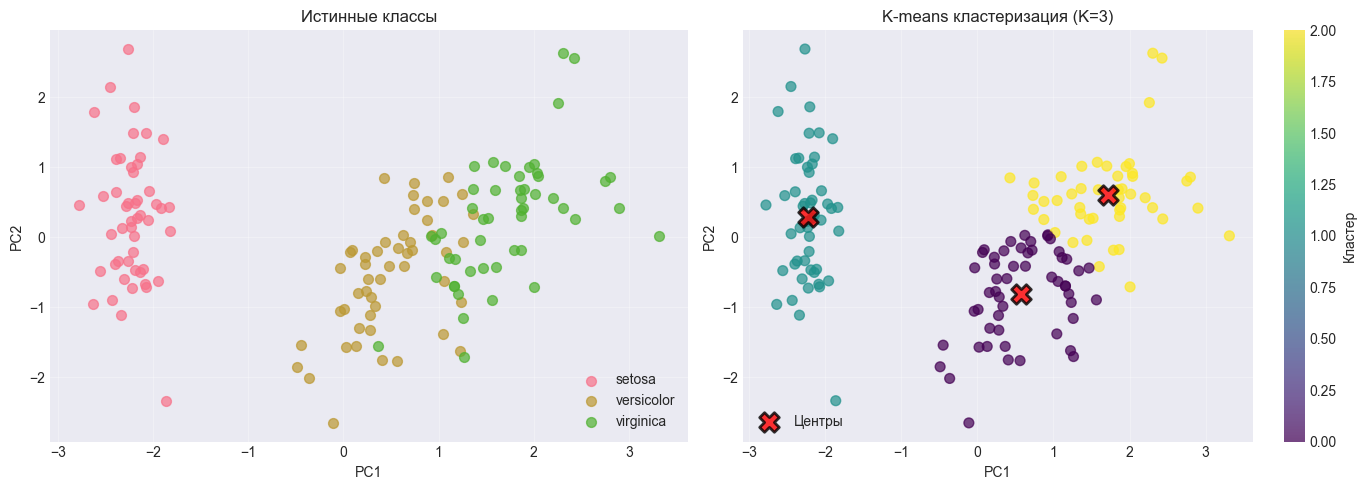

In [8]:
# K-means кластеризация
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_pca)

# Добавляем результаты кластеризации
df_pca['kmeans_cluster'] = clusters_kmeans

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Истинные метки
for i, species in enumerate(target_names):
    mask = df_pca['species'] == species
    axes[0].scatter(
        df_pca[mask]['PC1'],
        df_pca[mask]['PC2'],
        label=species,
        s=50,
        alpha=0.7
    )

axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('Истинные классы')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# K-means кластеры
scatter = axes[1].scatter(
    df_pca['PC1'],
    df_pca['PC2'],
    c=clusters_kmeans,
    s=50,
    alpha=0.7,
    cmap='viridis'
)

# Центры кластеров
centers = kmeans.cluster_centers_
axes[1].scatter(
    centers[:, 0],
    centers[:, 1],
    c='red',
    s=200,
    alpha=0.8,
    marker='X',
    edgecolors='black',
    linewidth=2,
    label='Центры'
)

axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('K-means кластеризация (K=3)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1], label='Кластер')

plt.tight_layout()
plt.show()

In [9]:
# Метод локтя для выбора оптимального K
inertias = []
K_range = range(1, 10)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_pca)
    inertias.append(kmeans_temp.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров (K)', fontsize=12)
plt.ylabel('Инерция (сумма квадратов расстояний)', fontsize=12)
plt.title('Метод локтя для выбора оптимального K', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axvline(x=3, color='r', linestyle='--', alpha=0.5, label='K=3 (выбранное значение)')
plt.legend()
plt.tight_layout()
plt.show()

print("\nИнтерпретация: ищите 'локоть' — точку, после которой снижение инерции замедляется")


Интерпретация: ищите 'локоть' — точку, после которой снижение инерции замедляется


### 3.2 Иерархическая кластеризация

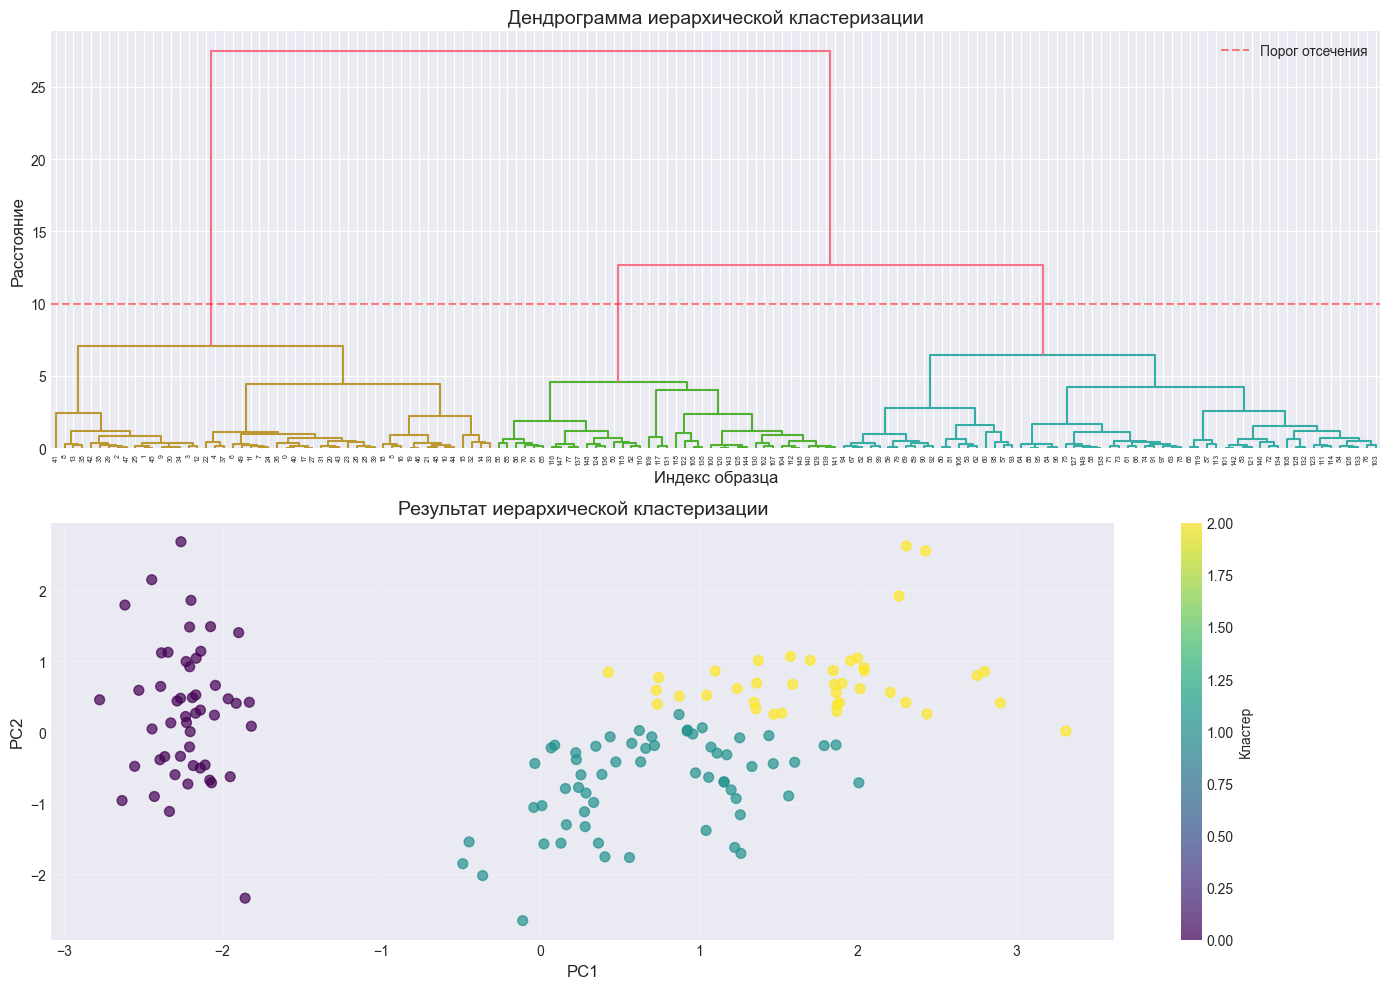

In [10]:
# Иерархическая кластеризация
hierarchical = AgglomerativeClustering(n_clusters=3)
clusters_hierarchical = hierarchical.fit_predict(X_pca)

df_pca['hierarchical_cluster'] = clusters_hierarchical

# Построение дендрограммы
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Дендрограмма
linkage_matrix = linkage(X_pca, method='ward')
dendrogram(
    linkage_matrix,
    ax=axes[0],
    color_threshold=10
)
axes[0].set_title('Дендрограмма иерархической кластеризации', fontsize=14)
axes[0].set_xlabel('Индекс образца', fontsize=12)
axes[0].set_ylabel('Расстояние', fontsize=12)
axes[0].axhline(y=10, color='r', linestyle='--', alpha=0.5, label='Порог отсечения')
axes[0].legend()

# Визуализация кластеров
scatter = axes[1].scatter(
    df_pca['PC1'],
    df_pca['PC2'],
    c=clusters_hierarchical,
    s=50,
    alpha=0.7,
    cmap='viridis'
)
axes[1].set_xlabel('PC1', fontsize=12)
axes[1].set_ylabel('PC2', fontsize=12)
axes[1].set_title('Результат иерархической кластеризации', fontsize=14)
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1], label='Кластер')

plt.tight_layout()
plt.show()

### 3.3 DBSCAN кластеризация

In [11]:
# DBSCAN кластеризация
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X_pca)

df_pca['dbscan_cluster'] = clusters_dbscan

# Визуализация
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_pca['PC1'],
    df_pca['PC2'],
    c=clusters_dbscan,
    s=50,
    alpha=0.7,
    cmap='viridis'
)

plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.title('DBSCAN кластеризация (выбросы помечены как -1)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Кластер')
plt.tight_layout()
plt.show()

n_clusters = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise = list(clusters_dbscan).count(-1)

print(f"Количество кластеров: {n_clusters}")
print(f"Количество выбросов: {n_noise}")

Количество кластеров: 2
Количество выбросов: 12


### 3.4 Сравнение методов кластеризации

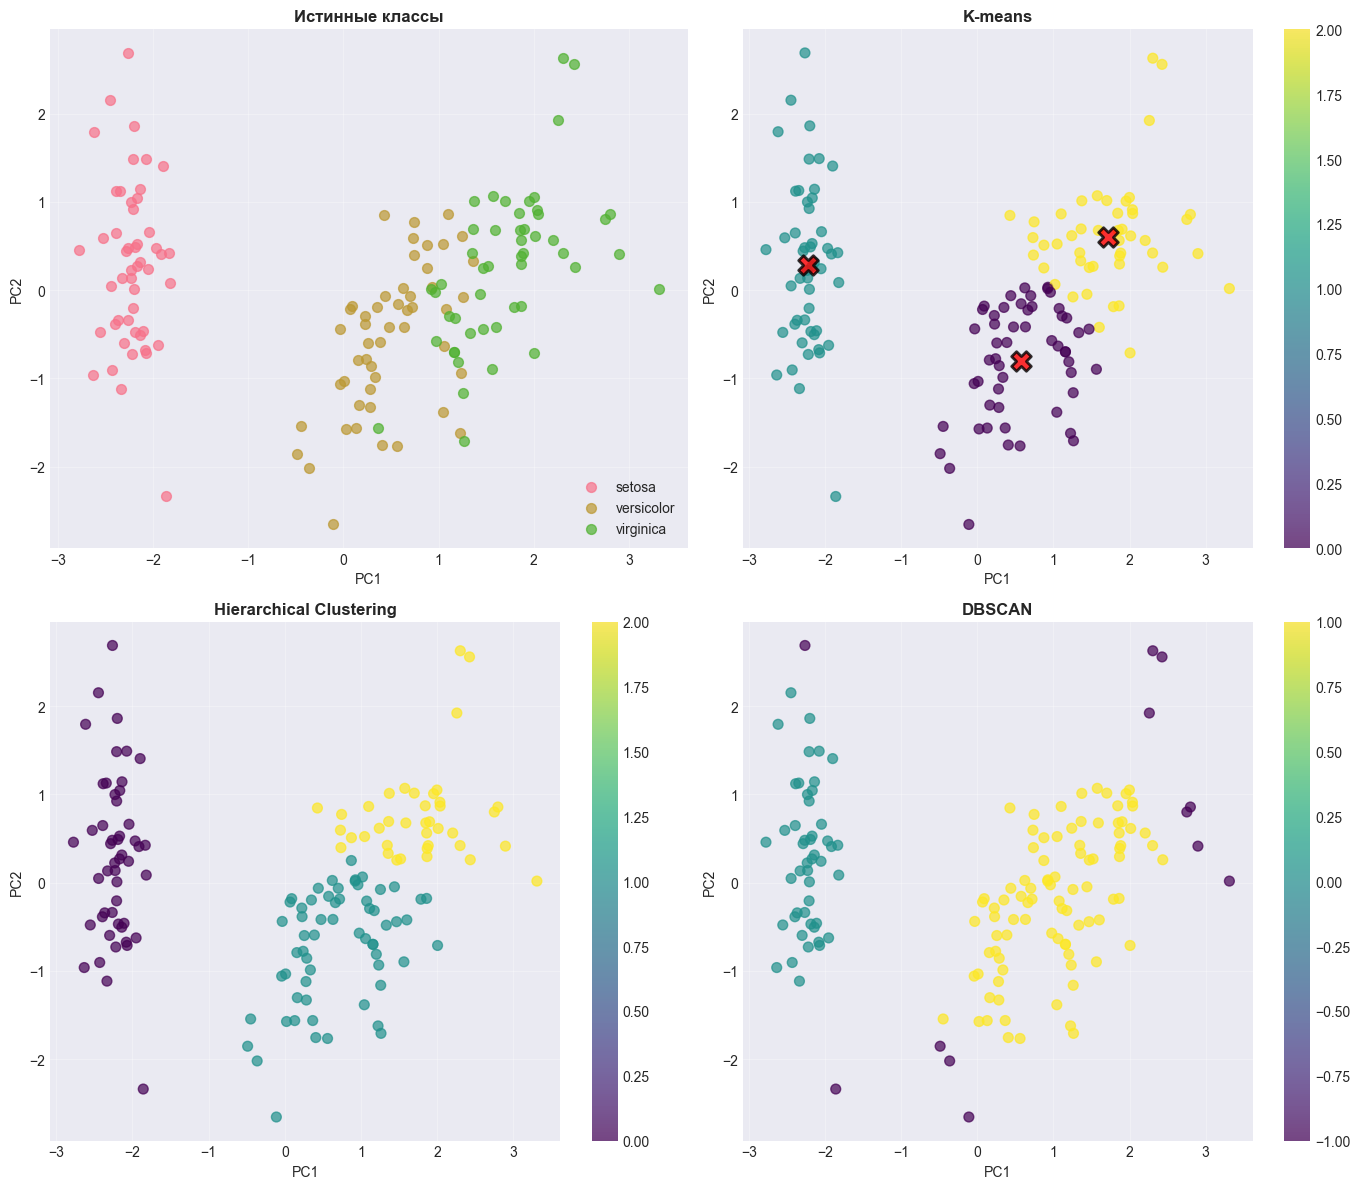

In [12]:
# Сравнение всех методов
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

# Истинные метки
for i, species in enumerate(target_names):
    mask = df_pca['species'] == species
    axes[0].scatter(
        df_pca[mask]['PC1'],
        df_pca[mask]['PC2'],
        label=species,
        s=50,
        alpha=0.7
    )
axes[0].set_title('Истинные классы', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# K-means
scatter1 = axes[1].scatter(
    df_pca['PC1'],
    df_pca['PC2'],
    c=clusters_kmeans,
    s=50,
    alpha=0.7,
    cmap='viridis'
)
axes[1].scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.8, marker='X', edgecolors='black', linewidth=2)
axes[1].set_title('K-means', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[1])

# Hierarchical
scatter2 = axes[2].scatter(
    df_pca['PC1'],
    df_pca['PC2'],
    c=clusters_hierarchical,
    s=50,
    alpha=0.7,
    cmap='viridis'
)
axes[2].set_title('Hierarchical Clustering', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[2])

# DBSCAN
scatter3 = axes[3].scatter(
    df_pca['PC1'],
    df_pca['PC2'],
    c=clusters_dbscan,
    s=50,
    alpha=0.7,
    cmap='viridis'
)
axes[3].set_title('DBSCAN', fontsize=12, fontweight='bold')
axes[3].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[3])

for ax in axes:
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

plt.tight_layout()
plt.show()

## 4. Сводка: Когда использовать каждый метод

### PCA
**Когда использовать:**
- Нужно визуализировать многомерные данные
- Нужно уменьшить размерность для ускорения вычислений
- Важно сохранить максимум дисперсии данных

**Биологические применения:**
- Визуализация RNA-seq данных
- Анализ популяционной структуры (генетика)
- Поиск паттернов в метаболомных данных

### ICA
**Когда использовать:**
- Данные представляют собой смесь независимых источников
- Нужно разделить перемешанные сигналы

**Биологические применения:**
- Анализ brain imaging (fMRI, ЭЭГ)
- Разделение сигналов от разных клеточных типов в bulk RNA-seq
- Удаление технических артефактов

### K-means
**Когда использовать:**
- Известно примерное количество кластеров
- Кластеры имеют сферическую форму и похожий размер
- Нужен быстрый алгоритм

**Биологические применения:**
- Классификация типов клеток в single-cell RNA-seq
- Группировка пациентов по профилям экспрессии

### Hierarchical Clustering
**Когда использовать:**
- Нужна иерархическая структура кластеров
- Количество кластеров неизвестно
- Важна визуализация взаимоотношений (дендрограмма)

**Биологические применения:**
- Построение филогенетических деревьев
- Кластеризация генов по профилям экспрессии (heatmap)
- Анализ микробиомных сообществ

### DBSCAN
**Когда использовать:**
- Кластеры имеют произвольную форму
- Есть выбросы в данных
- Количество кластеров неизвестно

**Биологические применения:**
- Анализ spatial transcriptomics
- Поиск редких клеточных популяций
- Обнаружение аномалий в данных

## 5. Практическое задание

Попробуйте применить изученные методы к своим данным:

1. Загрузите свои биологические данные
2. Примените PCA для визуализации
3. Попробуйте разные методы кластеризации
4. Сравните результаты
5. Проинтерпретируйте биологический смысл найденных паттернов

In [13]:
# Ваш код здесь
# Пример загрузки данных:
# data = pd.read_csv('your_data.csv')
# X = data.drop('target_column', axis=1).values
# y = data['target_column'].values